In [1]:
import numpy as np
# np.dict = dict
# np.object = object
# np.bool = bool
# np.int = int
# np.typeDict = dict
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import pixellib, ast, webcolors
import tensorflow as tf
import pandas as pd
import glob
import geopandas as gpd
import fiona
import logging
from pixellib.semantic import semantic_segmentation
# Disable all progress bars of pixellib, to not see anything




In [2]:
import os
import sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
segment_image = semantic_segmentation()
segment_image.load_ade20k_model("models/deeplabv3_xception65_ade20k.h5") # load network weights
segment_image.progress_bar = False

In [4]:
# get list of all files in directory data/images
import os
files = os.listdir('data/images')
files = [f for f in files if f.endswith('.jpg')] # filter to only include .jpg files
# maka dataframe from list of files with columns 'fi    lename' and 'path'
df = pd.DataFrame(files, columns=['filename'])
df

,filename
0,street_view_43.7329927-7.2123031-180.jpg
1,street_view_44.089252-6.9717029-180.jpg
2,street_view_43.94409695-7.0365838499999995-0.jpg
3,street_view_44.0985739-7.182033-0.jpg
4,street_view_43.9557449-7.3692276-90.jpg
...,...
18366,street_view_44.1025877-6.7978258-270.jpg
18367,street_view_44.1812287-7.1212167-90.jpg
18368,street_view_43.9258854-7.3309396-90.jpg
18369,street_view_43.7392172-7.3247874-90.jpg


In [5]:
def get_lon(x):
    return float(x.replace('street_view_','').replace('--','_*').replace('-','_').split('_')[1].replace('*','-'))
def get_angle(x):
    filesegments = x.replace('street_view_','').replace('--','_*').replace('-','_').split('_')
    if len(filesegments) < 3:
        return 'failed'
    return int(filesegments[2].replace('.jpg',''))
def get_lat(x):
    return float(x.replace('street_view_','').split('-')[0])

In [6]:
# parse filename to get 'lattitude' and 'longitude' and 'angle', having this name as example street_view_43.7329927-7.2123031-180.jpg
df['latitude'] = df['filename'].apply(get_lat)
df['longitude'] = df['filename'].apply(get_lon)
df['angle'] = df['filename'].apply(get_angle)
# filter out failed rows
df = df[df['angle']!='failed']
# filter out rows where longitute below 0
df = df[df['longitude']>0]
df

,filename,latitude,longitude,angle
0,street_view_43.7329927-7.2123031-180.jpg,43.732993,7.212303,180
1,street_view_44.089252-6.9717029-180.jpg,44.089252,6.971703,180
2,street_view_43.94409695-7.0365838499999995-0.jpg,43.944097,7.036584,0
3,street_view_44.0985739-7.182033-0.jpg,44.098574,7.182033,0
4,street_view_43.9557449-7.3692276-90.jpg,43.955745,7.369228,90
...,...,...,...,...
18366,street_view_44.1025877-6.7978258-270.jpg,44.102588,6.797826,270
18367,street_view_44.1812287-7.1212167-90.jpg,44.181229,7.121217,90
18368,street_view_43.9258854-7.3309396-90.jpg,43.925885,7.330940,90
18369,street_view_43.7392172-7.3247874-90.jpg,43.739217,7.324787,90


In [7]:
# get list of all unique points
points = df[['latitude','longitude']].drop_duplicates()
points

,latitude,longitude
0,43.732993,7.212303
1,44.089252,6.971703
2,43.944097,7.036584
3,44.098574,7.182033
4,43.955745,7.369228
...,...,...
9183,44.132403,6.730832
9194,43.733833,7.296814
9196,44.168512,7.040352
9200,44.163230,7.078233


<Axes: >

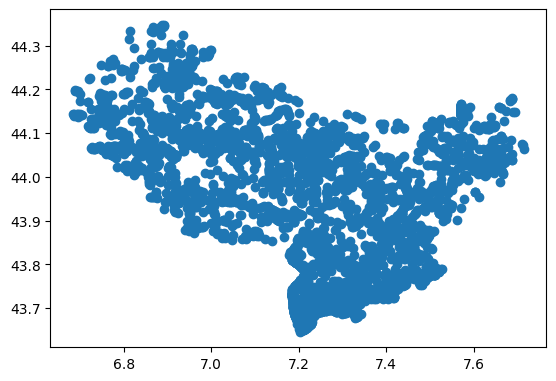

In [8]:
# create geodataframe from points and plot them
gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.longitude, points.latitude))
gdf.plot()

In [9]:
total_dataframe = pd.DataFrame(
    {
        'lat': [],
        'lon': [],
        'cars': [],
        'trees': [],
    }
)
# create a progress bar to see how much points out of gdf we have already processed in a loop
from tqdm import tqdm
pbar = tqdm(total=len(gdf))

for index, point in gdf.iterrows():
    
    # get list of all images for this point
    point_images = df[(df['latitude']==point.latitude) & (df['longitude']==point.longitude)] 
    # print(point_images)
    cars_ratio = 0
    trees_ratio = 0
    for _, image in point_images.iterrows():
        # print(image['filename'])
        path = 'data/images/' + image['filename']
        output_path = 'data/segmented-images/' + image['filename']

        # segment image
        with HiddenPrints():
            vals, overlay = segment_image.segmentAsAde20k(path, overlay=False, verbose=None)
            plt.imsave(output_path, overlay)

        vals_dataframe = pd.DataFrame( # create a format for the dataframe to store class values and information about them
            {
                "class names": vals['class_names'],
                "ratios,%": vals['ratios'],
                "class ids": vals['class_ids'],
                "class colors": vals['class_colors'],
            }
        )
        # print(vals_dataframe)
        cars = vals_dataframe[vals_dataframe['class names']=='car']
        trees = vals_dataframe[vals_dataframe['class names']=='tree']
        # get property 'ratios,%' for first row in cars and trees
        cars_ratio = cars_ratio + cars['ratios,%'].iloc[0] if len(cars)>0 else 0
        trees_ratio = trees_ratio + trees['ratios,%'].iloc[0] if len(trees)>0 else 0
    # print('cars_ratio', cars_ratio)
    # print('trees_ratio', trees_ratio)
    new_row = pd.DataFrame(
        {
            'lat': [point.latitude],
            'lon': [point.longitude],
            'cars': [cars_ratio],
            'trees': [trees_ratio],
        }
    )
    total_dataframe = pd.concat([total_dataframe, new_row], axis=0)
    # update progress bar
    pbar.update(1)
total_dataframe




  0%|          | 16/4541 [01:27<7:03:20,  5.61s/it]

,lat,lon,cars,trees
0,43.732993,7.212303,0.022888,17.591476
0,44.089252,6.971703,0.000000,0.088501
0,43.944097,7.036584,0.023651,77.975845
0,44.098574,7.182033,0.000000,0.088501
0,43.955745,7.369228,0.000000,0.088501
0,43.961264,7.199769,0.000000,0.088501
0,44.145284,7.200546,0.000000,0.088501
0,44.196143,6.695542,0.000000,0.088501
0,44.043422,7.601275,0.000000,0.088501
0,44.035452,6.828083,0.000000,32.650375


<Axes: >

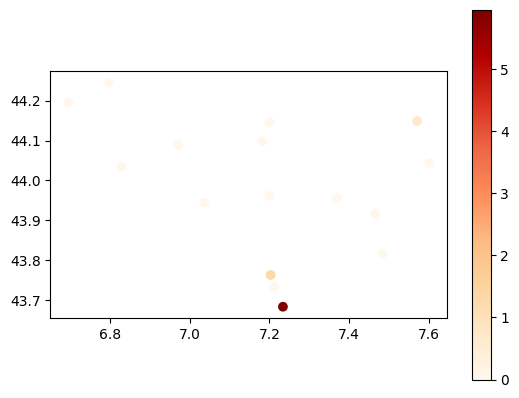

In [11]:
total_geodataframe = gpd.GeoDataFrame(total_dataframe, geometry=gpd.points_from_xy(total_dataframe.lon, total_dataframe.lat))
total_geodataframe.to_file('data/result.geojson', driver='GeoJSON')
total_geodataframe.plot(column='cars', cmap='OrRd', legend=True)
